# Balancing Market: Accepted vs Activated Volumes (Up/Down)

This notebook loads three NO1 balancing CSVs (2023–now) and plots accepted and activated up/down regulation volumes. It standardizes columns, concatenates yearly files, aggregates to daily totals, and produces clear line plots with optional weekly/monthly views.

In [2]:
# 1) Import Libraries and Configure Paths
import os
import sys
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
# If running from upreg_classify/notebooks, repo root is two levels up's parent[1]
if Path.cwd().name == 'notebooks':
    REPO_ROOT = Path.cwd().parents[1]
else:
    # Fallback: assume we're somewhere under repo root; go up until we find .git or the folder name
    cur = Path.cwd()
    while cur.name and cur.name != 'rl_reserve_markets' and cur.parent != cur:
        cur = cur.parent
    REPO_ROOT = cur if cur.name == 'rl_reserve_markets' else Path.cwd().parent.parent

DATA_DIR = REPO_ROOT / 'upreg_classify' / 'data' / 'raw' / 'balancing'

# Allow project imports
UPREG_ROOT = REPO_ROOT / 'upreg_classify'
sys.path.insert(0, str(UPREG_ROOT))

try:
    from src.data.preprocess import ensure_datetime_index
except Exception as e:
    raise RuntimeError(f"Could not import ensure_datetime_index: {e}")

print('Repo root:', REPO_ROOT)
print('Data dir :', DATA_DIR)
assert DATA_DIR.exists(), f"Data dir not found: {DATA_DIR}"


Repo root: c:\PythonProjects\rl_reserve_markets
Data dir : c:\PythonProjects\rl_reserve_markets\upreg_classify\data\raw\balancing


In [3]:
# 2) Discover and Validate Balancing CSV Files (NO1 only)
all_csvs = sorted(glob.glob(str(DATA_DIR / 'BalanceMarket_*_NO1_*_MW.csv')))
print('Found NO1 CSVs:', len(all_csvs))
for p in all_csvs:
    try:
        size_mb = os.path.getsize(p) / (1024*1024)
    except OSError:
        size_mb = float('nan')
    print(f" - {Path(p).name} | {size_mb:.2f} MB")

# Expect exactly three NO1 CSVs for 2023, 2024, 2025
assert len(all_csvs) == 3, f"Expected 3 NO1 CSVs, found {len(all_csvs)}: {all_csvs}"


Found NO1 CSVs: 3
 - BalanceMarket_2023_NO1_EUR_None_MW.csv | 0.91 MB
 - BalanceMarket_2024_NO1_EUR_None_MW.csv | 2.23 MB
 - BalanceMarket_2025_NO1_EUR_None_MW.csv | 1.96 MB


In [5]:
# 3) Define Column Mapping and Parsing Helpers

# Possible aliases for the columns across files
COLMAP = {
    'time': ['Delivery Start (CET)', 'Delivery Start', 'Time'],
    'accepted_up': [
        'NO1 Accepted Up Volume (MW)', 'Accepted Up Volume (MW)',
        'SE2 Accepted Up Volume (MW)'
    ],
    'accepted_down': [
        'NO1 Accepted Down Volume (MW)', 'Accepted Down Volume (MW)',
        'SE2 Accepted Down Volume (MW)'
    ],
    'activated_up': [
        'NO1 Activated Up Volume (MW)', 'Activated Up Volume (MW)',
        'SE2 Activated Up Volume (MW)'
    ],
    'activated_down': [
        'NO1 Activated Down Volume (MW)', 'Activated Down Volume (MW)',
        'SE2 Activated Down Volume (MW)'
    ],
}

STD_COLUMNS = [
    'time',
    'accepted_up_mw', 'accepted_down_mw',
    'activated_up_mw', 'activated_down_mw'
]


def find_first_match(columns, candidates):
    for c in candidates:
        if c in columns:
            return c
    # fallback: case-insensitive contains check
    lower = {c.lower(): c for c in columns}
    for cand in candidates:
        for lc, orig in lower.items():
            if cand.lower() in lc:
                return orig
    return None


def standardize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns
    time_col = find_first_match(cols, COLMAP['time'])
    aup_col = find_first_match(cols, COLMAP['accepted_up'])
    adown_col = find_first_match(cols, COLMAP['accepted_down'])
    iup_col = find_first_match(cols, COLMAP['activated_up'])
    idown_col = find_first_match(cols, COLMAP['activated_down'])

    if time_col is None:
        raise ValueError('Could not find time column alias in dataframe')

    out = pd.DataFrame()
    out['time'] = df[time_col]

    def to_float(series):
        # Replace comma decimal and non-breaking spaces, then coerce
        return pd.to_numeric(
            series.astype(str)
                  .str.replace('\u00a0', '', regex=False)
                  .str.replace(' ', '', regex=False)
                  .str.replace(',', '.', regex=False),
            errors='coerce'
        )

    if aup_col is not None:
        out['accepted_up_mw'] = to_float(df[aup_col])
    if adown_col is not None:
        out['accepted_down_mw'] = to_float(df[adown_col])
    if iup_col is not None:
        out['activated_up_mw'] = to_float(df[iup_col])
    if idown_col is not None:
        out['activated_down_mw'] = to_float(df[idown_col])

    # Ensure all standard columns exist
    for c in STD_COLUMNS:
        if c not in out.columns:
            out[c] = np.nan

    return out[STD_COLUMNS]


In [6]:
# 4) Load, Normalize, and Concatenate Datasets
frames = []
for csv_path in all_csvs:
    print('Loading:', Path(csv_path).name)
    df_raw = pd.read_csv(csv_path, sep=';', engine='python')
    df_std = standardize_dataframe(df_raw)
    df_std['source_file'] = Path(csv_path).name
    frames.append(df_std)

full = pd.concat(frames, ignore_index=True)
# Drop rows where all four volume columns are NaN
vol_cols = ['accepted_up_mw','accepted_down_mw','activated_up_mw','activated_down_mw']
full = full.dropna(subset=vol_cols, how='all')
print('Rows after concat and NaN drop:', len(full))
full.head()


Loading: BalanceMarket_2023_NO1_EUR_None_MW.csv
Loading: BalanceMarket_2024_NO1_EUR_None_MW.csv
Loading: BalanceMarket_2025_NO1_EUR_None_MW.csv
Rows after concat and NaN drop: 79803


,time,accepted_up_mw,accepted_down_mw,activated_up_mw,activated_down_mw,source_file
0,01.01.2023 00:00:00,447,104,0.0,0.0,BalanceMarket_2023_NO1_EUR_None_MW.csv
1,01.01.2023 01:00:00,522,97,0.0,0.0,BalanceMarket_2023_NO1_EUR_None_MW.csv
2,01.01.2023 02:00:00,619,48,0.0,0.0,BalanceMarket_2023_NO1_EUR_None_MW.csv
3,01.01.2023 03:00:00,634,37,0.0,10.0,BalanceMarket_2023_NO1_EUR_None_MW.csv
4,01.01.2023 04:00:00,709,34,0.0,10.0,BalanceMarket_2023_NO1_EUR_None_MW.csv


In [7]:
# 5) Set Datetime Index and Filter Date Range
# Rename 'time' to 'Time' temporarily for ensure_datetime_index compatibility
full = full.rename(columns={'time': 'Time'})
full = ensure_datetime_index(full, 'Time', fmt='%d.%m.%Y %H:%M:%S')
full = full[~full.index.duplicated(keep='first')].sort_index()

start = pd.Timestamp('2023-01-01')
end = pd.Timestamp.now(tz=None)
full = full.loc[(full.index >= start) & (full.index <= end)]
assert len(full) > 0, 'No rows after date filtering'

print('Date range:', full.index.min(), '→', full.index.max())
print('Total rows :', len(full))
full.head(3)


Date range: 2023-01-01 00:00:00 → 2025-11-13 23:45:00
Total rows : 79791


,accepted_up_mw,accepted_down_mw,activated_up_mw,activated_down_mw,source_file
Time,,,,,
2023-01-01 00:00:00,447,104,0.0,0.0,BalanceMarket_2023_NO1_EUR_None_MW.csv
2023-01-01 01:00:00,522,97,0.0,0.0,BalanceMarket_2023_NO1_EUR_None_MW.csv
2023-01-01 02:00:00,619,48,0.0,0.0,BalanceMarket_2023_NO1_EUR_None_MW.csv


In [8]:
# 6) Select and Cast Accepted/Activated Up/Down Columns
vol_cols = ['accepted_up_mw','accepted_down_mw','activated_up_mw','activated_down_mw']
for c in vol_cols:
    if c not in full.columns:
        full[c] = 0.0
full[vol_cols] = full[vol_cols].fillna(0.0).astype(float)

up_accepted_pos = (full['accepted_up_mw'] > 0).sum()
up_activated_pos = (full['activated_up_mw'] > 0).sum()
down_accepted_pos = (full['accepted_down_mw'] > 0).sum()
down_activated_pos = (full['activated_down_mw'] > 0).sum()

print({'up_accepted_pos': up_accepted_pos,
       'up_activated_pos': up_activated_pos,
       'down_accepted_pos': down_accepted_pos,
       'down_activated_pos': down_activated_pos})


{'up_accepted_pos': np.int64(77431), 'up_activated_pos': np.int64(10508), 'down_accepted_pos': np.int64(78251), 'down_activated_pos': np.int64(22886)}


In [9]:
# 7) Aggregate Volumes to Daily/Weekly/Monthly Totals
DAILY = full.resample('1D')[['accepted_up_mw','activated_up_mw','accepted_down_mw','activated_down_mw']].sum()
WEEKLY = full.resample('1W')[['accepted_up_mw','activated_up_mw','accepted_down_mw','activated_down_mw']].sum()
MONTHLY = full.resample('1MS')[['accepted_up_mw','activated_up_mw','accepted_down_mw','activated_down_mw']].sum()

print('Daily rows  :', len(DAILY))
print('Weekly rows :', len(WEEKLY))
print('Monthly rows:', len(MONTHLY))
DAILY.head(3)


Daily rows  : 1048
Weekly rows : 151
Monthly rows: 35


,accepted_up_mw,activated_up_mw,accepted_down_mw,activated_down_mw
Time,,,,
2023-01-01,12253.0,108.3,2196.0,155.7
2023-01-02,9172.0,164.6,1923.0,0.0
2023-01-03,7879.0,922.5,3491.0,0.0


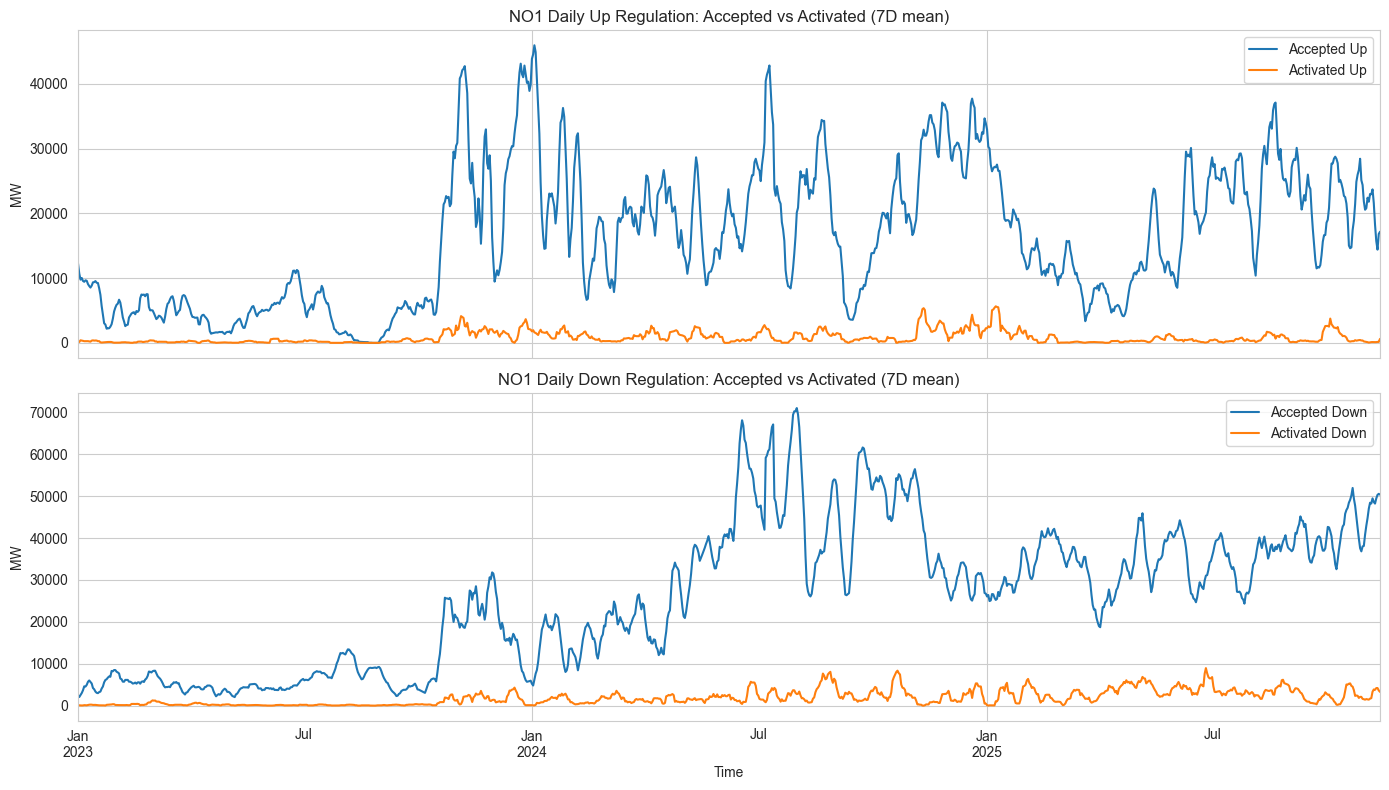

In [10]:
# 8) Plot Daily Accepted vs Activated Volumes (Up/Down)
plt.close('all')
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Up regulation
ax = axes[0]
DAILY[['accepted_up_mw','activated_up_mw']].rolling(7, min_periods=1).mean().plot(ax=ax)
ax.set_title('NO1 Daily Up Regulation: Accepted vs Activated (7D mean)')
ax.set_ylabel('MW')
ax.legend(['Accepted Up','Activated Up'])

# Down regulation
ax = axes[1]
DAILY[['accepted_down_mw','activated_down_mw']].rolling(7, min_periods=1).mean().plot(ax=ax)
ax.set_title('NO1 Daily Down Regulation: Accepted vs Activated (7D mean)')
ax.set_ylabel('MW')
ax.legend(['Accepted Down','Activated Down'])

plt.tight_layout()
plt.show()


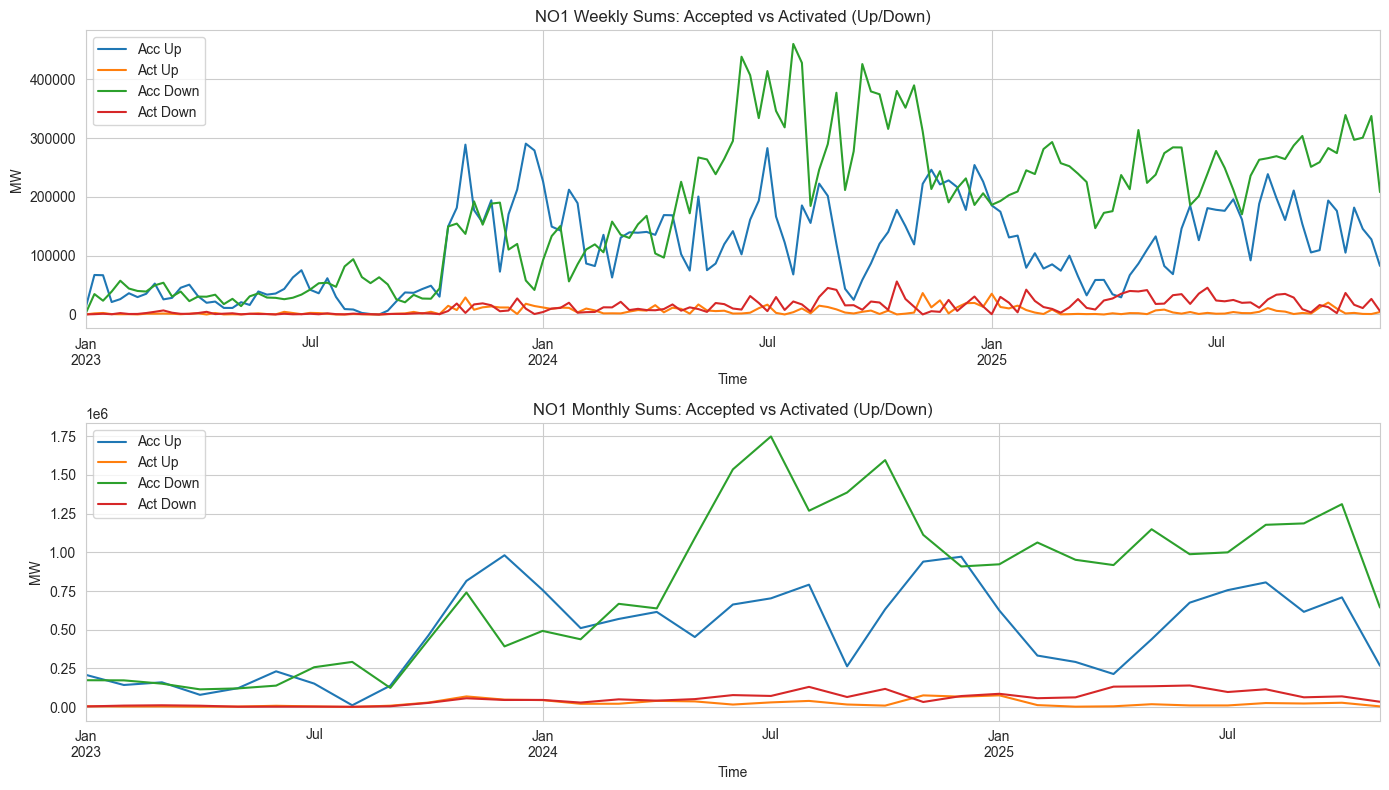

In [11]:
# 9) Optional: Weekly/Monthly Aggregations and Plots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
ax = axes[0]
WEEKLY[['accepted_up_mw','activated_up_mw','accepted_down_mw','activated_down_mw']].plot(ax=ax)
ax.set_title('NO1 Weekly Sums: Accepted vs Activated (Up/Down)')
ax.set_ylabel('MW')
ax.legend(['Acc Up','Act Up','Acc Down','Act Down'])

ax = axes[1]
MONTHLY[['accepted_up_mw','activated_up_mw','accepted_down_mw','activated_down_mw']].plot(ax=ax)
ax.set_title('NO1 Monthly Sums: Accepted vs Activated (Up/Down)')
ax.set_ylabel('MW')
ax.legend(['Acc Up','Act Up','Acc Down','Act Down'])

plt.tight_layout()
plt.show()


In [12]:
# 10) Save Figures and Export Aggregated Data
from pathlib import Path

fig_dir = REPO_ROOT / 'upreg_classify' / 'reports' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)

# Rebuild plots quickly to save
plt.figure(figsize=(14,4))
DAILY[['accepted_up_mw','activated_up_mw']].rolling(7, min_periods=1).mean().plot()
plt.title('NO1 Daily Up Regulation: Accepted vs Activated (7D mean)')
plt.ylabel('MW')
plt.tight_layout()
up_path = fig_dir / 'no1_daily_up_accepted_vs_activated_7d.png'
plt.savefig(up_path, dpi=150)
plt.close()

plt.figure(figsize=(14,4))
DAILY[['accepted_down_mw','activated_down_mw']].rolling(7, min_periods=1).mean().plot()
plt.title('NO1 Daily Down Regulation: Accepted vs Activated (7D mean)')
plt.ylabel('MW')
plt.tight_layout()
down_path = fig_dir / 'no1_daily_down_accepted_vs_activated_7d.png'
plt.savefig(down_path, dpi=150)
plt.close()

# Export daily aggregate
out_csv = REPO_ROOT / 'upreg_classify' / 'reports' / 'dataframes' / 'balancing_agg_daily_2023_to_now.csv'
out_csv.parent.mkdir(parents=True, exist_ok=True)
DAILY.to_csv(out_csv)

print('Saved figures to:', fig_dir)
print('Exported daily aggregate to:', out_csv)


Saved figures to: c:\PythonProjects\rl_reserve_markets\upreg_classify\reports\figures
Exported daily aggregate to: c:\PythonProjects\rl_reserve_markets\upreg_classify\reports\dataframes\balancing_agg_daily_2023_to_now.csv


<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>